# PyTorch Layer 이해하기

# 예제 불러오기

In [1]:
import torch
from torchvision import datasets, transforms

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/content/dataset', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=1)

Extracting /content/dataset/MNIST/raw/train-images-idx3-ubyte.gz to /content/dataset/MNIST/raw


Extracting /content/dataset/MNIST/raw/train-labels-idx1-ubyte.gz to /content/dataset/MNIST/raw



Extracting /content/dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/dataset/MNIST/raw


Extracting /content/dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/dataset/MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [4]:
image, label = next(iter(train_loader))

In [5]:
image.shape, label.shape

(torch.Size([1, 1, 28, 28]), torch.Size([1]))

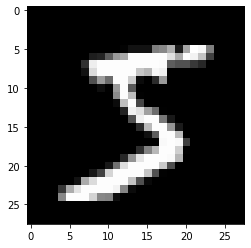

In [7]:
plt.imshow(image[0,0,:,:], 'gray')
plt.show()

# 각 Layer별 설명

- Network 쌓기 위한 준비

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### Convolution

- in_channels: 받게 될 channel의 갯수
- out_channels: 보내고 싶은 channel의 갯수  
- kernel_size: 만들고 싶은 kernel(weights)의 사이즈

In [9]:
nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

In [10]:
layer = nn.Conv2d(1, 20, 5, 1).to(torch.device('cpu'))
layer

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

- weight 시각화를 위해 slice하고 numpy화

In [11]:
weight = layer.weight
weight.shape

torch.Size([20, 1, 5, 5])

- 여기서 weight는 학습 가능한 상태이기 때문에 바로 numpy로 뽑아낼 수 없음
- detach() method는 그래프에서 잠깐 빼서 gradient에 영향을 받지 않게 함

In [12]:
weight = weight.detach().numpy()

In [14]:
weight.shape

(20, 1, 5, 5)

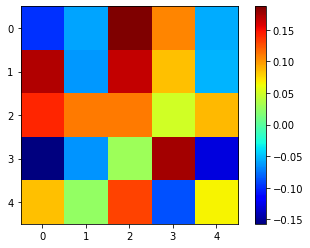

In [15]:
plt.imshow(weight[0,0,:,:],'jet')
plt.colorbar()
plt.show()

- output 시각화 준비를 위해 numpy화

In [21]:
output_data = layer(image)

In [22]:
output = output_data.data.cpu().numpy()

In [23]:
output.shape

(1, 20, 24, 24)

- Input으로 들어간 이미지 numpy화 

In [24]:
image_arr = image.numpy()
image_arr.shape

(1, 1, 28, 28)

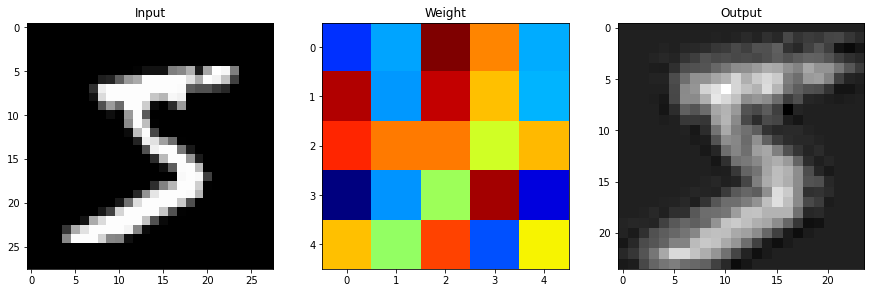

In [25]:
plt.figure(figsize=(15,30))
plt.subplot(131)
plt.title('Input')
plt.imshow(np.squeeze(image_arr), 'gray')
plt.subplot(132)
plt.title('Weight')
plt.imshow(weight[0,0,:,:], 'jet')
plt.subplot(133)
plt.title('Output')
plt.imshow(output[0,0,:,:], 'gray')
plt.show()

### Pooling

input을 먼저 앞에 넣고, 뒤에 kernel 사이즈와 stride를 순서대로 넣음

In [26]:
image.shape

torch.Size([1, 1, 28, 28])

In [27]:
pool = F.max_pool2d(image, 2,2)
pool.shape

torch.Size([1, 1, 14, 14])

- MaxPool Layer는 weight가 없기 때문에 바로 numpy()가 가능

In [28]:
pool_arr = pool.numpy()
pool_arr.shape

(1, 1, 14, 14)

In [29]:
image_arr.shape

(1, 1, 28, 28)

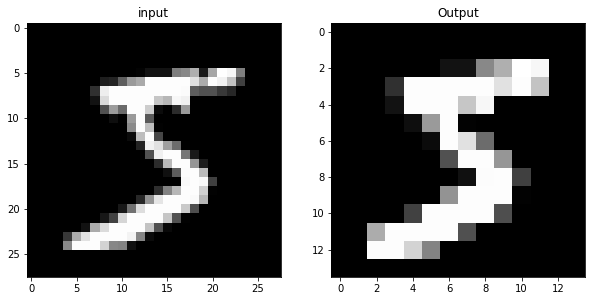

In [32]:
plt.figure(figsize=(10,15))
plt.subplot(121)
plt.title('input')
plt.imshow(np.squeeze(image_arr), 'gray')
plt.subplot(122)
plt.title('Output')
plt.imshow(np.squeeze(pool_arr), 'gray')
plt.show()

### Linear

nn.Linear는 2d가 아닌 1d만 들어가기 때문에 .view() 1D로 펼쳐줘야함

In [33]:
image.shape

torch.Size([1, 1, 28, 28])

In [34]:
flatten = image.view(1, 28 * 28 )
flatten.shape

torch.Size([1, 784])

In [35]:
lin = nn.Linear(784, 10)(flatten)
lin.shape

torch.Size([1, 10])

In [36]:
lin

tensor([[-0.1585, -0.0090,  0.1731, -0.1947,  0.1184, -0.1972, -0.0116,  0.0138,
         -0.4108, -0.3222]], grad_fn=<AddmmBackward>)

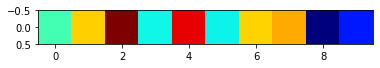

In [39]:
plt.imshow(lin.detach().numpy(), 'jet') # lin에는 weight가 있기 때문에 detach해줘야 에러 x
plt.show()

### Softmax

결과를 numpy로 꺼내기 위해선 weight가 담긴 Linear에 weight를 꺼줘야함

In [40]:
with torch.no_grad():
  flatten = image.view(1, 28 * 28)
  lin = nn.Linear(784, 10)(flatten)
  softmax = F.softmax(lin, dim=1)

In [41]:
softmax

tensor([[0.0878, 0.1262, 0.1291, 0.0821, 0.1166, 0.1162, 0.0781, 0.0949, 0.0788,
         0.0902]])

In [42]:
np.sum(softmax.numpy())

1.0

# Layer 쌓기

예제 출처: https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#id23

nn 과 nn.functional의 차이점
- nn은 학습 파라미터가 담긴 것 
- nn.functional은 학습 파라미터가 없는 것이라 생각하면 간단

In [63]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 20, 5, 1)
    self.conv2 = nn.Conv2d(20, 50, 5, 1)
    self.fc1 = nn.Linear(4*4*50, 500)
    self.fc2 = nn.Linear(500, 10)
  def forward(self, x):
    # Feature Extraction
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)

    # Fully Connected (Classification)
    x = x.view(-1, 4*4*50)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

- Image를 Model에 넣어서 결과 확인

In [64]:
model = Net()

In [65]:
result = model.forward(image)

In [66]:
result

tensor([[-2.2374, -2.3226, -2.3830, -2.3335, -2.2763, -2.2951, -2.3162, -2.3269,
         -2.2683, -2.2743]], grad_fn=<LogSoftmaxBackward>)